This is just a fraction of the Lab1, excercise 7 "Real world example" of the UK Gaussian Process Summer School from 2024 that Giang Tran (GEOMAR, gtran@geomar.de) kindly pointed me to. I (Ana C. Franco) simply copied the excercises and code. Full credits to the creators of this jupyter-notebook and more info about the summer school at the end. 

Here is the link to the complete Lab: https://nbviewer.org/github/gpschool/labs/blob/2024/answers/lab_1.ipynb

### Real World Example: 
We'll consider now a classic real world example using atmospheric  CO2  observations from the Mauna Loa Observatory, Hawaii. The dataset is a good demonstration of the predictive power of Gaussian processes, and we will use it to show how we can encode our prior beliefs to combine kernels.

First, we need to setup our notebook with the libraries we are going to use. We will use numpy for maths functionality, pyplot for plotting, and of course GPy for Gaussian processes.

In [1]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

Then, download the dataset.

In [2]:
import pickle
import requests

# Load in the data
req = requests.get('https://github.com/gpschool/labs/raw/2023/.resources/mauna_loa')
data = pickle.loads(req.content)
    
print("\nData keys:")
print(data.keys())

print("\nCitation:")
print(data['citation'])

print("\nInfo:")
print(data['info'])


Data keys:
dict_keys(['X', 'Y', 'Xtest', 'Ytest', 'info', 'citation', 'details', 'files', 'license', 'size', 'urls'])

Citation:
Mauna Loa Data. Dr. Pieter Tans, NOAA/ESRL (www.esrl.noaa.gov/gmd/ccgg/trends/) and Dr. Ralph Keeling, Scripps Institution of Oceanography (scrippsco2.ucsd.edu/).

Info:
Mauna Loa data with 545 values used as training points.


Next, they define a **quick plotting utility** function for our GP fits. There are a number of plotting options available in GPy, but we will use the method below, which plots the mean and 95% confidence fit of a GP for a given input $\mathbf{X}^*$. Optionally, we will allow it to plot the initial training points.

In [3]:
def plot_gp(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval
    plt.fill_between(X[:,0],
                     m[:,0] - 1.96*np.sqrt(np.diag(C)),
                     m[:,0] + 1.96*np.sqrt(np.diag(C)),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X_, Y_ = training_points
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

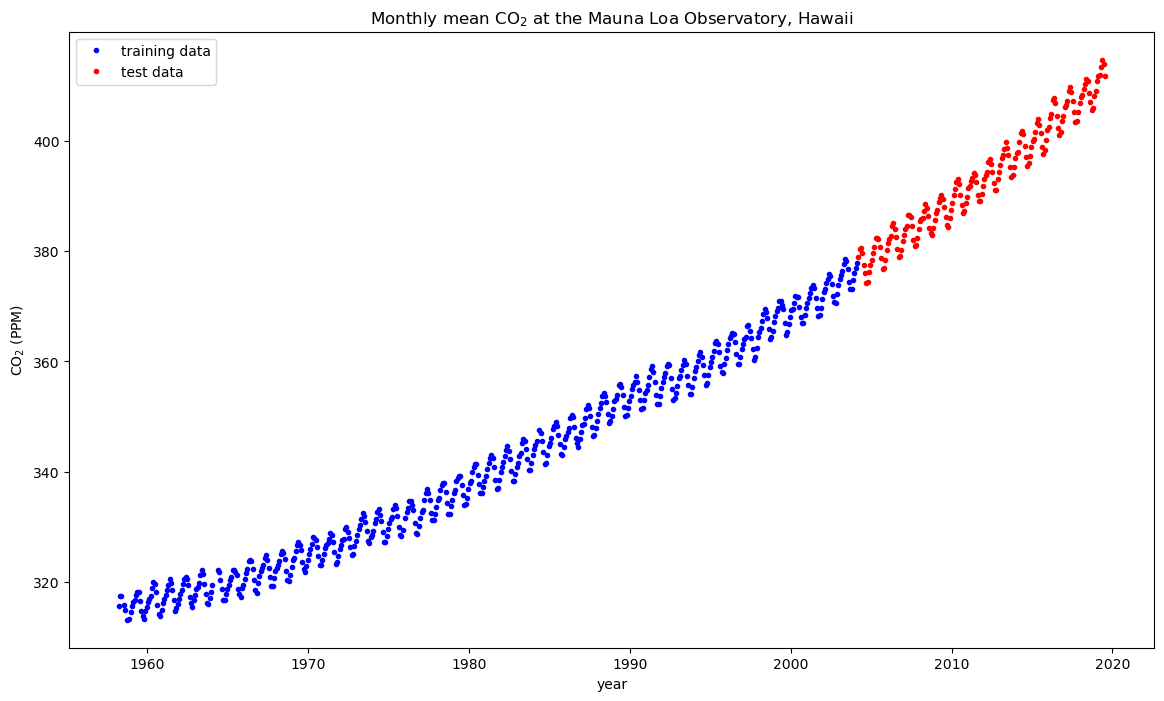

In [4]:
# Training data (X = input, Y = observation)
X, Y = data['X'], data['Y']

# Test data (Xtest = input, Ytest = observations)
Xtest, Ytest = data['Xtest'], data['Ytest']

# Set up our plotting environment
plt.figure(figsize=(14, 8))

# Plot the training data in blue and the test data in red
plt.plot(X, Y, "b.", Xtest, Ytest, "r.")

# Annotate plot
plt.legend(labels=["training data", "test data"])
plt.xlabel("year"), plt.ylabel("CO$_2$ (PPM)"), plt.title("Monthly mean CO$_2$ at the Mauna Loa Observatory, Hawaii");

**You may want to subsample the data to save time during the labs**

Run the following to reduce the datasize by only using every other training point:

In [5]:
X = X[::2, :]
Y = Y[::2, :]

### Naive GP regression

First, we will try to fit a basic RBF to our data, as we have used in previous examples

In [6]:
k = GPy.kern.RBF(1, name="rbf")

m = GPy.models.GPRegression(X, Y, k)
m.optimize()

m

GP_regression.,value,constraints,priors
rbf.variance,121454.28733738296,+ve,
rbf.lengthscale,101.50283302533744,+ve,
Gaussian_noise.variance,4.578115754270079,+ve,


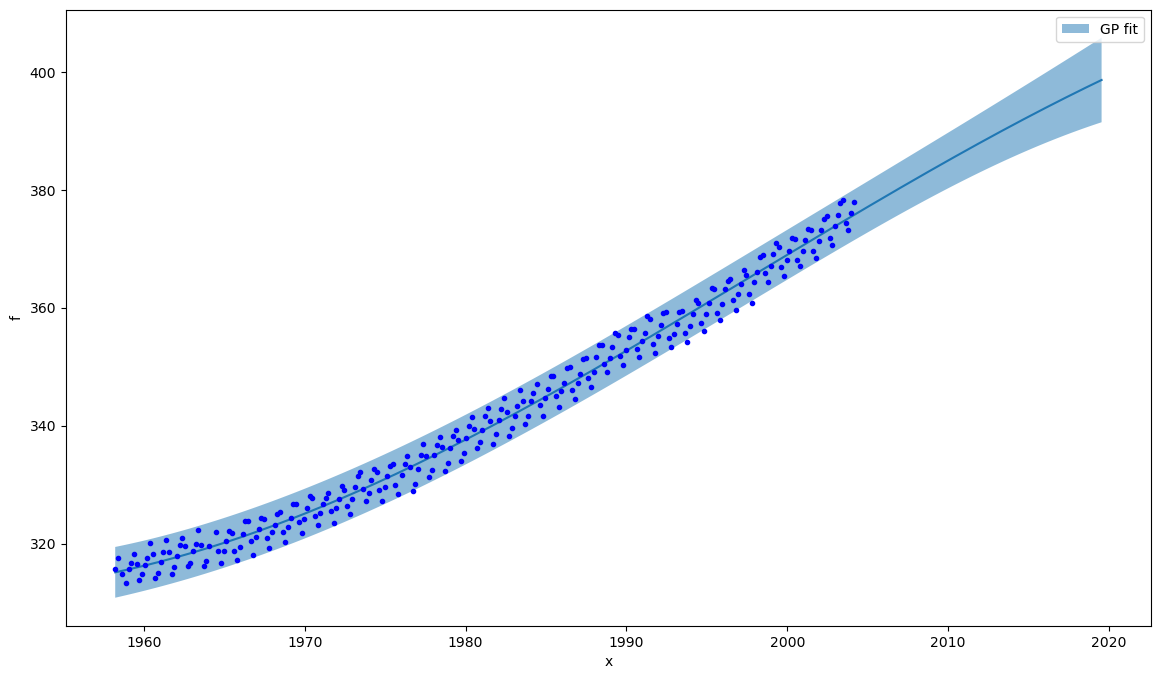

In [7]:
Xnew = np.vstack([X, Xtest])

mean, Cov = m.predict(Xnew, full_cov=True)

plt.figure(figsize=(14, 8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

It is possible to make the model fit the data near perfectly by minimising the variance of the Gaussian noise in the likelihood and fixing the kernel variance.



In [8]:
# Effectively remove noise parameter (needs to be >0, so select value that is very low)
m.Gaussian_noise.variance = 0.00001
m.Gaussian_noise.variance.fix()

# We will fix the variance as well, so that only the lengthscale is optimised
m.rbf.variance = 10.
m.rbf.variance.fix()

# This should minimize the lengthscale to fit closely to the training points
m.optimize()
m

GP_regression.,value,constraints,priors
rbf.variance,10.0,+ve fixed,
rbf.lengthscale,9.720798737268005e-105,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


**But** this has no predictive power, and we have really just overfitted to the training data



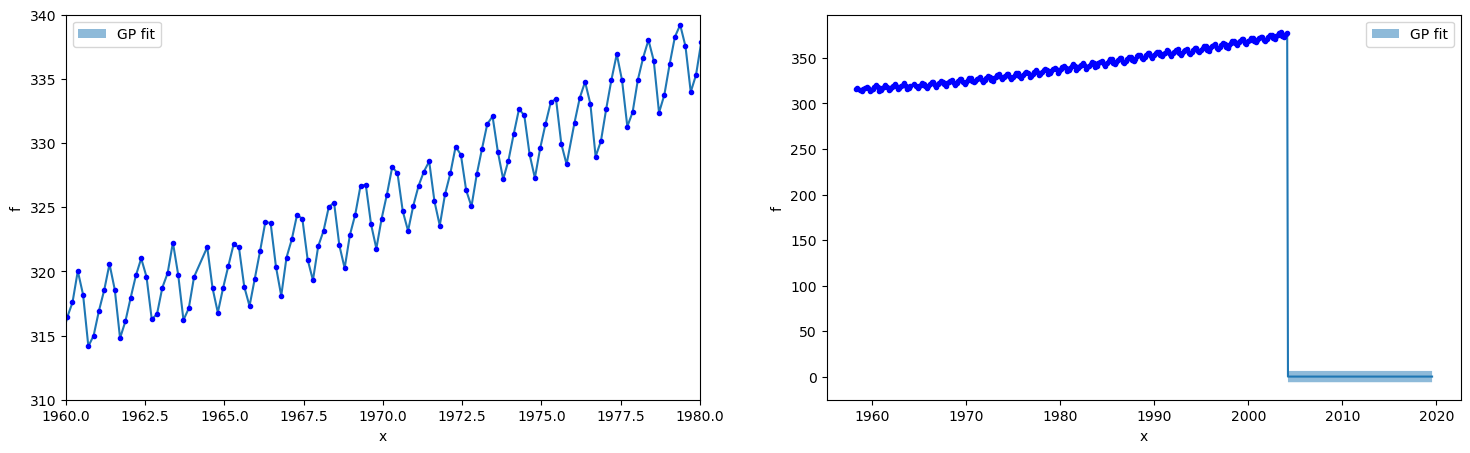

In [9]:
mean, Cov = m.predict(Xnew, full_cov=True)

plt.figure(figsize=(18, 5))

# The left plot shows the GP fit to a subsample of our training set
plt.subplot(121)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");
plt.gca().set_xlim([1960,1980]), plt.gca().set_ylim([310, 340])

# The right plot shows that the GP has no predictive power and reverts to 0
plt.subplot(122)
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, "b.");

### GP Regression with combined covariance functions

Taking a look at the training data, we can see a number of features that occur in the data. There is a clear periodic trend that is yearly, and an approximately linear trend. We can use this prior information in our choice of kernel to give some meaning to the GP fit.

First, we will look at the linear trend. It should be obvious that the overall trend (ignoring the periodicity) can be described approximately by $f(x) \approx a + bx$. To embed this as a covariance function, we can use the  `Linear` covariance functions, which adds a linear trend to the covariance.

### Exercise 6

(a) Create a `Linear` kernel with reasonable estimates of the parameters that represent the trend?

In [10]:
k_L = GPy.kern.Linear(1, variances=[1.])

(b) How might we encode this trend in the mean estimate of the GP ?

(c) Create a GP regression model using the kernels to fit the data. Comment on good is the fit and the predictive power of the model?

GP_regression.,value,constraints,priors
sum.linear.variances,1.0,+ve,
sum.bias.variance,360.0,+ve,
Gaussian_noise.variance,1.0,+ve,


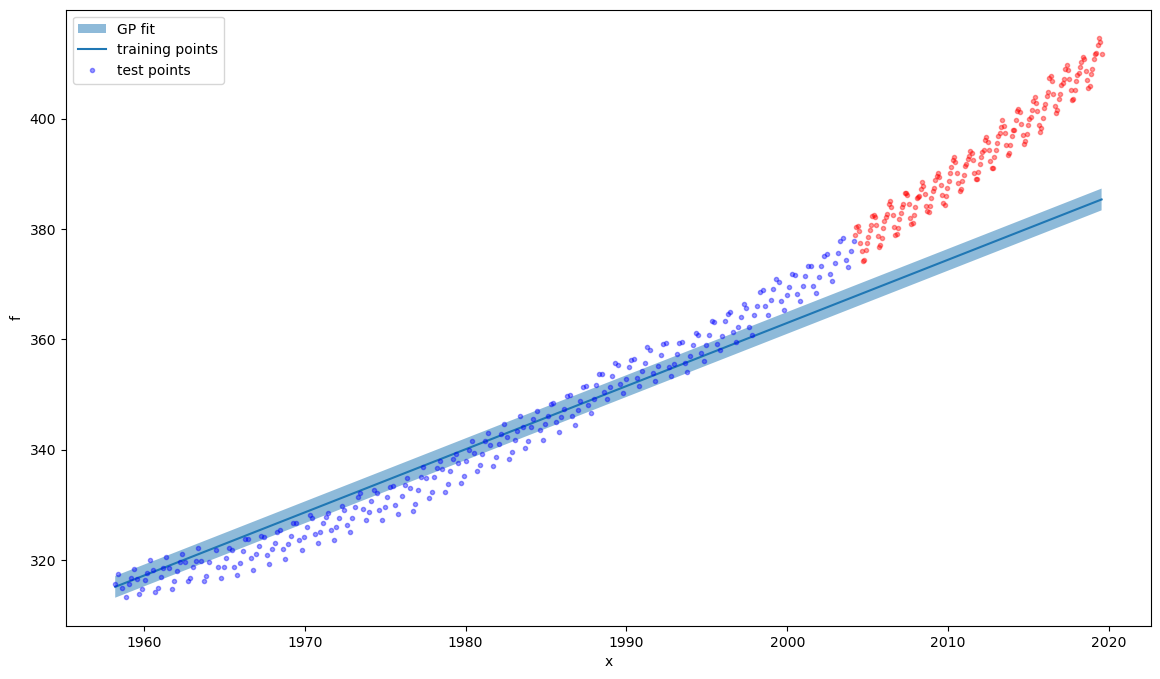

In [11]:
#Linear covariance function
m1 = GPy.models.GPRegression(
    X, Y, 
    kernel = GPy.kern.Linear(1, variances=[1.]) + GPy.kern.Bias(1, 360)
)

mean, Cov = m1.predict(Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"])

display(m1)

GP_regression.,value,constraints,priors
mapping.linmap.A,[-0.55937054],,
mapping.constmap.C,360.0,,
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


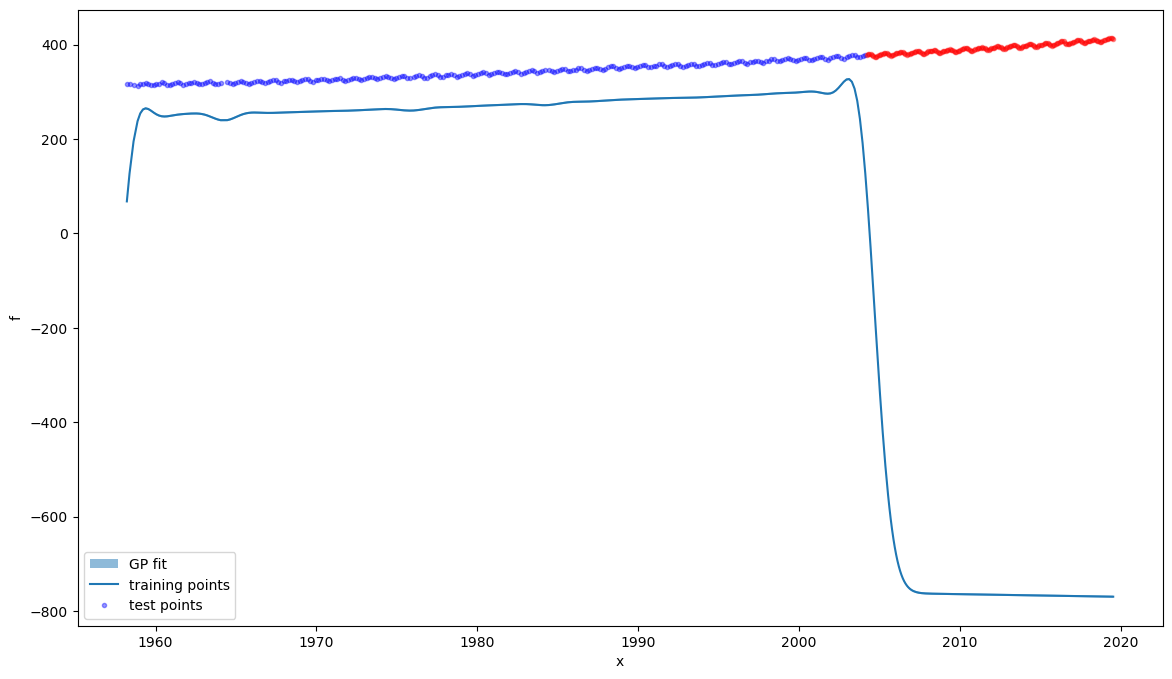

In [12]:
# Linear mapping function (with RBF kernel)

mean_func = GPy.mappings.Additive(
    GPy.mappings.Linear(1, 1), # gradient
    GPy.mappings.Constant(1, 1, value=360) # intercept
)

m2 = GPy.models.GPRegression(
    X, Y, 
    kernel = GPy.kern.RBF(1),
    mean_function=mean_func
)

mean, Cov = m2.predict(Xnew)

plt.figure(figsize=(14,8))
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
plt.legend(labels=["GP fit","training points", "test points"])

display(m2)

### Periodicity

There is a seasonal trend over the year, and that a simple linear fit cannot capture this information. However, we can add this using our choice of kernel by adding a `StdPeriodic` kernel to our regression model. It's evident to the data that the period is yearly, so a period of $\omega=1$ is a sensible choice for our initial parameter:

GP_regression.,value,constraints,priors
sum.bias.variance,13897.382865442867,+ve,
sum.linear.variances,32785.176307321235,+ve,
sum.std_periodic.variance,315315.2944924254,+ve,
sum.std_periodic.period,0.9964927104293013,+ve,
sum.std_periodic.lengthscale,1294.4721497952069,+ve,
Gaussian_noise.variance,3.8045106755422293,+ve,


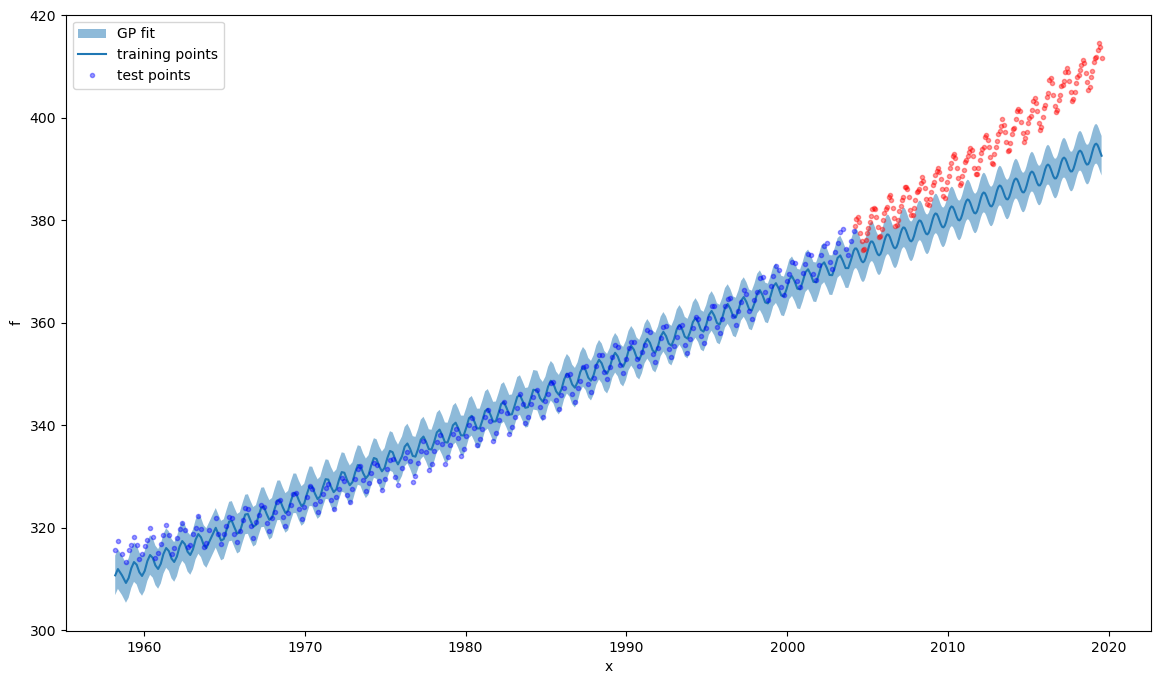

In [13]:
ks = [ # Our kernels
    GPy.kern.Bias(1, variance=10000.),    # Constant offset
    GPy.kern.Linear(1),                   # Linear trend
    GPy.kern.StdPeriodic(1, period=1)     # Periodicity
]

# Create a regression model with an additive kernel (bias + linear + periodic)
m = GPy.models.GPRegression(X, Y, ks[0] + ks[1] + ks[2])

# Optimise hyperparameters to maximise likelihood
m.optimize()

# Predict the value of CO2 using our GP fit
mean, Cov = m.predict(Xnew)

# Set up plotting
plt.figure(figsize=(14,8))

# Plot GP fit
plot_gp(Xnew, mean, Cov)
# Show our training and test points
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4)
# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"])

# Preview the parameters of our model
m

From the plot we can see that while we have maintained the periodicity in our prediction, there is some deviation in the amplitude of each period. Likewise, the data is not strictly linear. We can embed model these non-linearities and deviations by adding an `Exponential` kernel. First, in the summative kernel, but also by multiplying a Gaussian RBF by the periodic kernel. For some intiution on how this allows for deviation of the periodicity, see the corresponding sample plot in Section 4.

Note that the `Exponential` kernel describes an exponential decay in covariance with distance between points, and does **not** model an exponential trend in the overall data. The `RBF` kernel describes a smoother (Gaussian) decay, which may be a better model for changes in the periodic signal.

In [14]:
ks = [ # Our kernels
    GPy.kern.Exponential(1),              # Non-linearity in overall trend
    GPy.kern.Bias(1, variance=10000.),    # Constant offset
    GPy.kern.Linear(1),                   # Linear trend
    GPy.kern.StdPeriodic(1, period=1.),   # Periodicity (short term trend)
    GPy.kern.RBF(1)                       # Amplitude modulator (long term trend)
]

# Composite kernel: exponential + bias + linear + (periodic * rbf)
k = ks[0] + ks[1] + ks[2] + ks[3]*ks[4]
k

sum.,value,constraints,priors
Exponential.variance,1.0,+ve,
Exponential.lengthscale,1.0,+ve,
bias.variance,10000.0,+ve,
linear.variances,1.0,+ve,
mul.std_periodic.variance,1.0,+ve,
mul.std_periodic.period,1.0,+ve,
mul.std_periodic.lengthscale,1.0,+ve,
mul.rbf.variance,1.0,+ve,
mul.rbf.lengthscale,1.0,+ve,


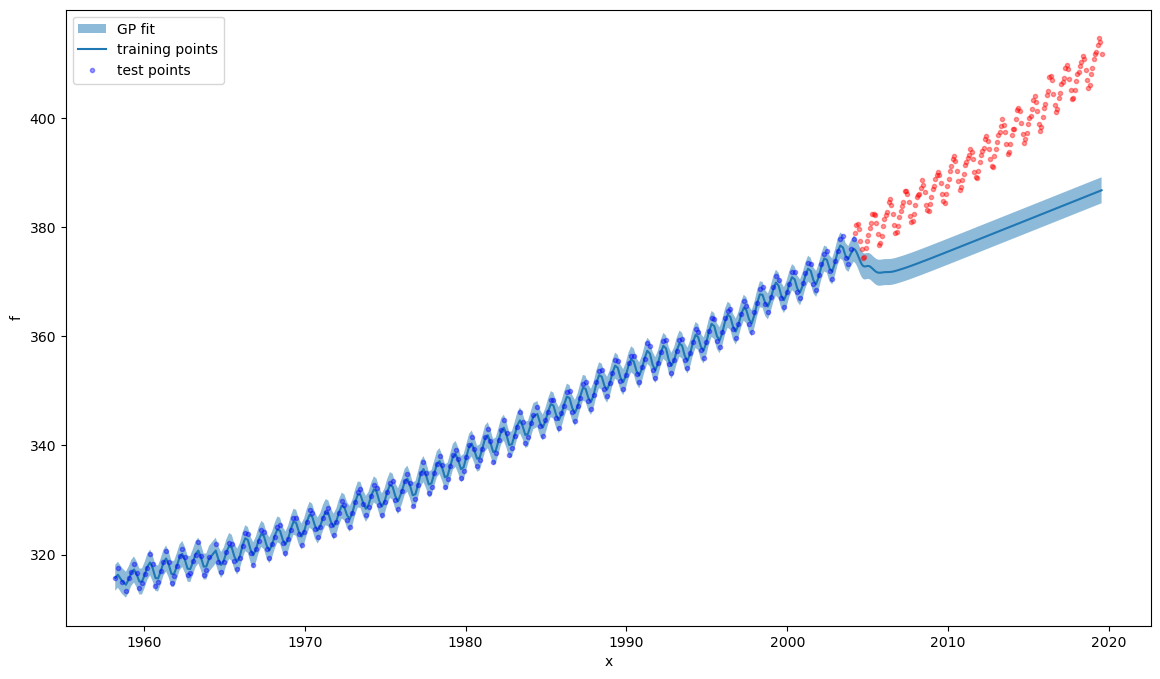

In [15]:
# Create our GP regression model with the composite kernel
m = GPy.models.GPRegression(X, Y, k)

# Predict the CO2 at the training and test locations
mean, Cov = m.predict(Xnew)

# Setup figure
plt.figure(figsize=(14,8))

# Plot the GP fit and training points
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);

# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"]);

We can see that with even with our initial (mostly default) parameter choices, the GP fit to the training data is representative of the trends we are observing. However, the prediction of the test data is relatively poor (though we still have an upward trend). The obvious step now is to optimise our kernel parameters.

Optimisation of the GP in itself is imperfect, often because the likelihood we are maximising can be multimodal, or flat, and so it can get stuck in local-maxima. It is always important to sanity-check the GP fit when optimising the parameters, to mitigate problems that could occur as a result (such as the minimised noise example we saw earlier). One of the ways to avoid the problem of local maxima is to reinitialise the optimiser with different starting locations, and take the maximum of these outputs. This is possible in GPy using optimize_restarts(n), which will optimise the parameters  n  times and take the best estimate.

Optimization restart 1/5, f = 150.4779509502057
Optimization restart 2/5, f = 524.7219732907195
Optimization restart 3/5, f = 214.2468194839015
Optimization restart 4/5, f = 266.7389331445964
Optimization restart 5/5, f = 634.1305411524022


GP_regression.,value,constraints,priors
sum.Exponential.variance,16.745780462503934,+ve,
sum.Exponential.lengthscale,44.22121361758548,+ve,
sum.bias.variance,10000.04211504942,+ve,
sum.linear.variances,0.8608641324784838,+ve,
sum.mul.std_periodic.variance,100.14746706248498,+ve,
sum.mul.std_periodic.period,0.9992203399022106,+ve,
sum.mul.std_periodic.lengthscale,3.814987740461035,+ve,
sum.mul.rbf.variance,100.14746706246292,+ve,
sum.mul.rbf.lengthscale,152.82707629519203,+ve,
Gaussian_noise.variance,1.7722908078868658e-34,+ve,


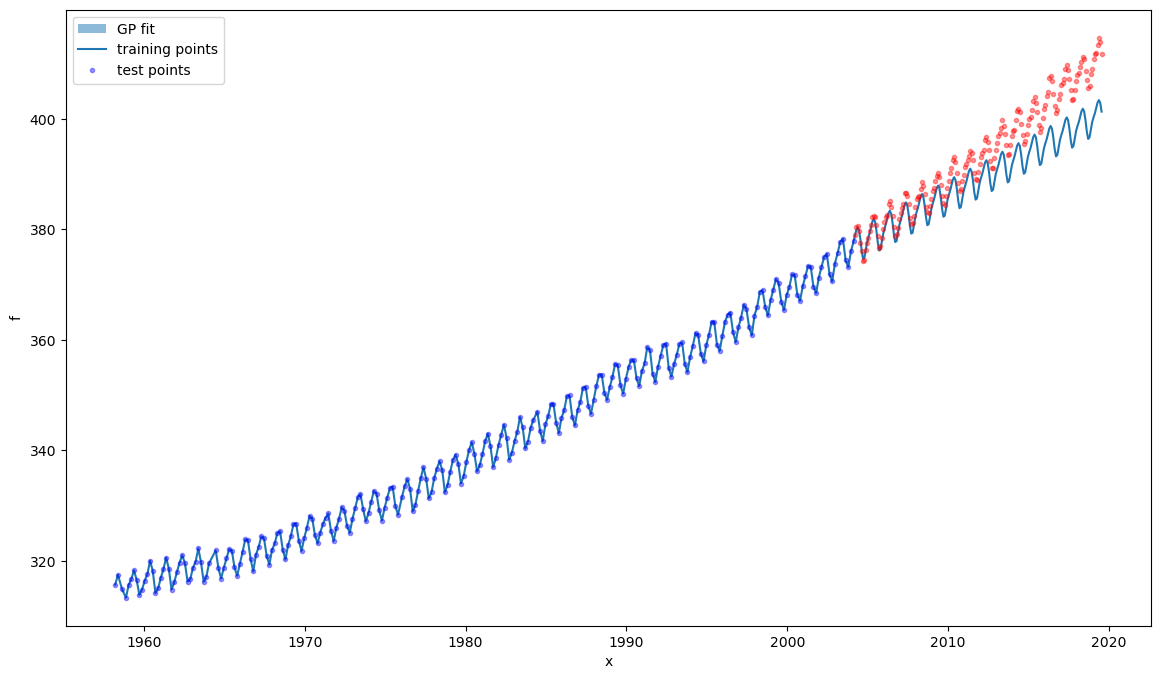

In [16]:
# Optimise hyperparameters 5 times to get a good estimate
m.optimize_restarts(5, robust=True) # We could do this more times, but it can be quite time consuming

# Get the moments of our model fit
mean, Cov = m.predict(Xnew)

# Set up plot environment
plt.figure(figsize=(14,8))

# Plot our optimised GP and training/test points
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"])
# Preview model parameters
m

We can see from the output of the optimiser that there are a number of different minima in the negative log-likelihood (corresponding to maxima in the likelihood), implying that there are several modes. However, it's possible to get a good fit of the function with a GP with great predictive power. You might try allowing the optimiser to run for more iterations when you have more time.

We can also look at the effects of each kernel on the GP model, which will show the features that it represents in the fit. For example, we expect the `Bias` to capture the offset, and the `Exponential` kernel to extract most of the non-linearity (that's not explained by the periodicity). We can view the effects of each of the components and the combination of them to see how they deconstruct the training data. This shows what features are being learned by which kernel.

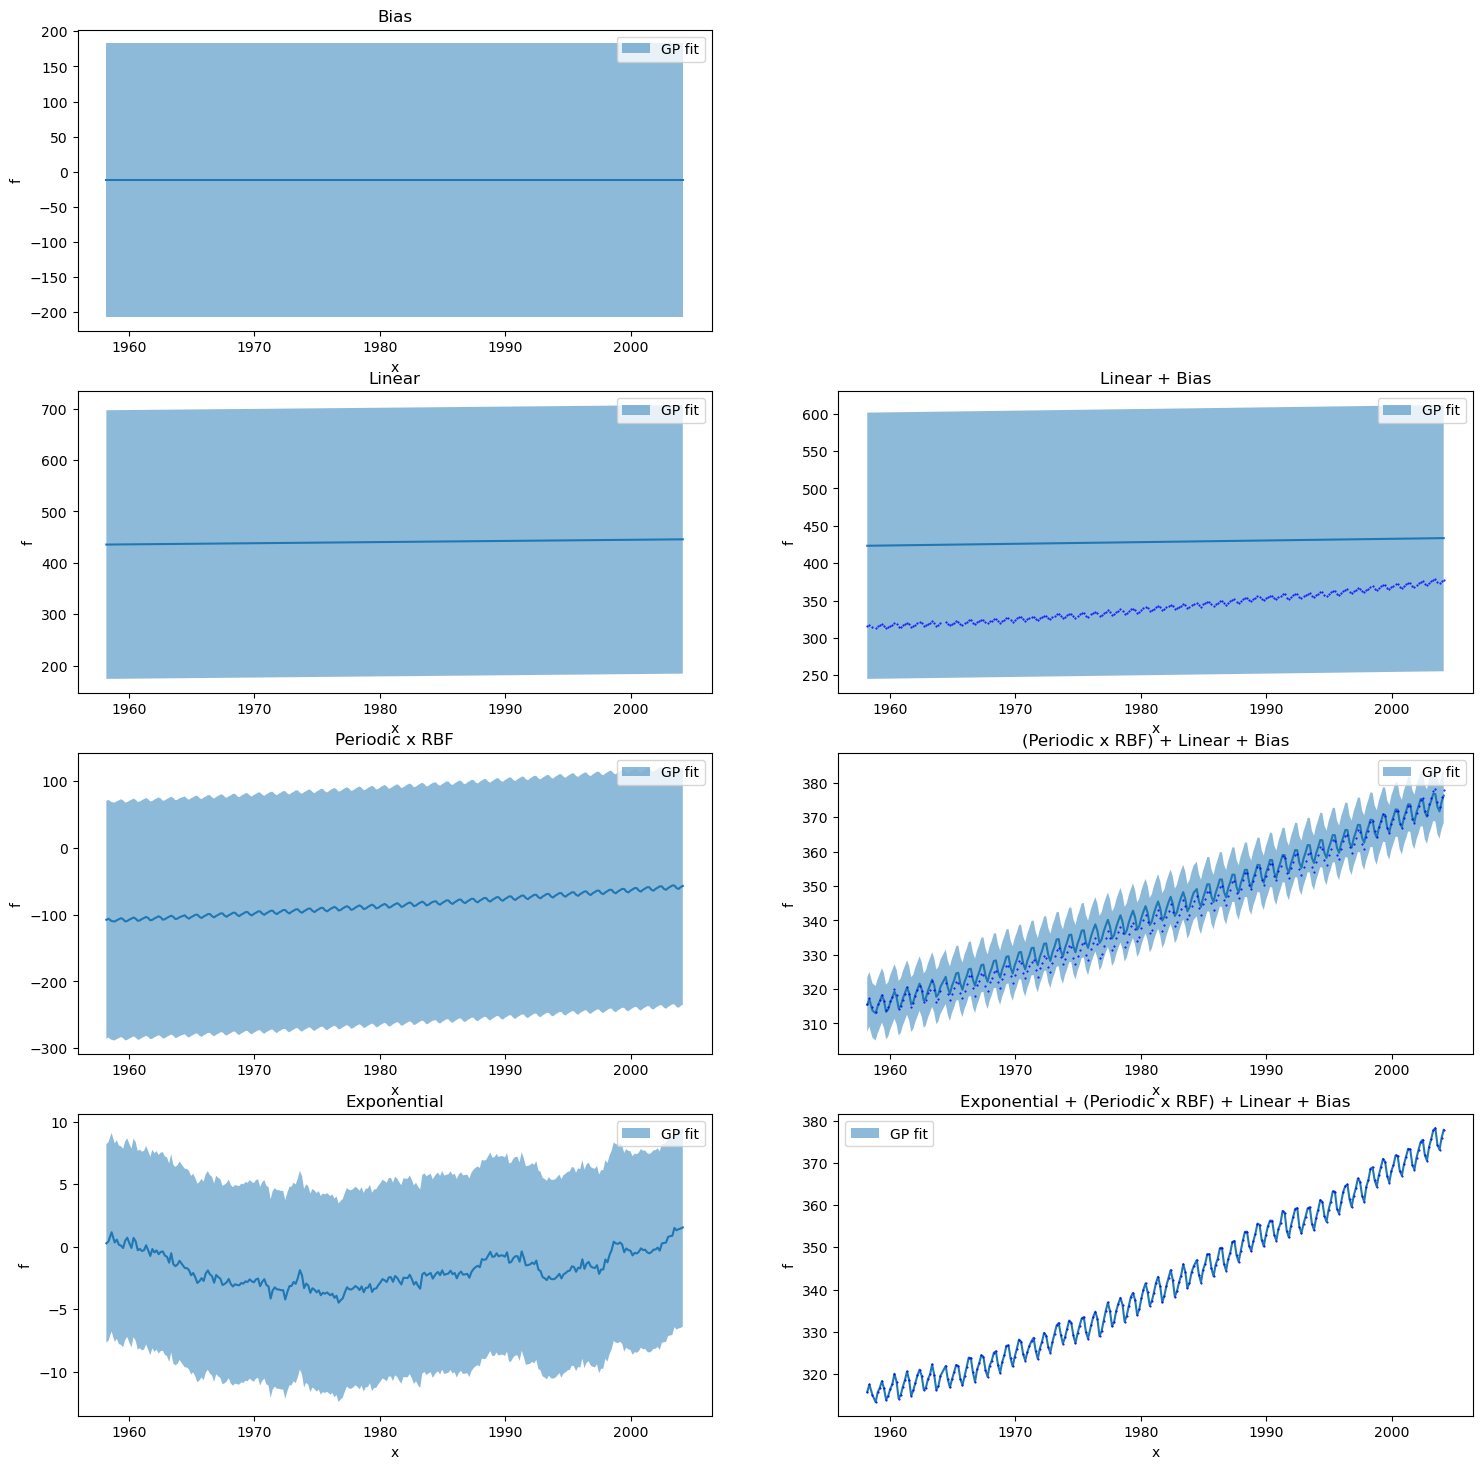

In [17]:
# Setup figure environment (4x2 grid)
plt.figure(figsize=(18,18))

# Show Bias kernel effect
plt.subplot(421)
mean, Cov = m.predict_noiseless(X, kern=m.sum.bias)
plot_gp(X, mean, Cov)
plt.title("Bias")

# Show Linear kernel effect
plt.subplot(423)
mean, Cov = m.predict_noiseless(X, kern=m.sum.linear)
plot_gp(X, mean, Cov)
plt.title("Linear")

# Show combination of Bias and Linear kernels
plt.subplot(424)
mean, Cov = m.predict_noiseless(X, kern=m.sum.linear + m.sum.bias)
plot_gp(X, mean, Cov)
plt.plot(X, Y, ".b", ms=1.)
plt.title("Linear + Bias")

# Show modulated Periodic x RBF kernel
plt.subplot(425)
mean, Cov = m.predict_noiseless(X, kern=m.sum.mul)
plot_gp(X, mean, Cov)
plt.title("Periodic x RBF")

# Show combination of Periodic, Bias and Linear kernels
plt.subplot(426)
mean, Cov = m.predict_noiseless(X, kern=m.sum.mul + m.sum.linear + m.sum.bias)
plot_gp(X, mean, Cov)
plt.plot(X, Y, ".b", ms=1.)
plt.title("(Periodic x RBF) + Linear + Bias")

# Show Exponential kernel effect
plt.subplot(427)
mean, Cov = m.predict_noiseless(X, kern=m.sum.Exponential)
plot_gp(X, mean, Cov)
plt.title("Exponential")

# Show combination of Periodic, Bias, Linear and Exponential kernel (this is our full GP fit !)
plt.subplot(428)
mean, Cov = m.predict_noiseless(X, kern=m.sum.Exponential + m.sum.mul + m.sum.linear + m.sum.bias)
plot_gp(X, mean, Cov)
plt.plot(X, Y, ".b", ms=1.)
plt.title("Exponential + (Periodic x RBF) + Linear + Bias");

It's clear that while our final fit is very good, some of the kernel effects are not as clear cut as we expected. For example, much of the upward trend is captured by the periodic combination, likely due to its ability to vary non-linearly. However, we can see that, for example, the Exponential kernel has a clear purpose in adjusting the GP fit to the data.

**What improvements might be made to the GP model, for example in terms combinations of kernels and parameters, to get a better fit, especially for the prediction of our testing data?**

How clear the differing effects of the kernels are is dependent on the random seed, and the number of optimisation restarts of the hyperparameters. However something that can be observed is that trying to embed the linear trend in the covariance function with a nonlinear periodic function is largely redundant as the periodic*rbf kernel is clearly capturing most of the upward trend. We might play around with smoother non-linear kernels, for example adding a higher order Matern than exponential (3/2 or 5/2). We can also make use of kernels not shown in this lab, such as the periodic Matern kernels.

Another option is to embed our linear trend in the mean function of our GP prior. While this is not especially common in machine learning, if we have reliable prior assumptions of the model, we can embed this explicitly. Putting a prior over the parameters of the linear mean function would keep the Bayesian approach to learning the model, but would allow us to fit periodicity to the data independent(ish) of the linear mapping.

Optimization restart 1/20, f = 358.0920251980025
Optimization restart 2/20, f = 476.5269944554194
Optimization restart 3/20, f = 390.2215598051565
Optimization restart 4/20, f = 515.4830143868624
Optimization restart 5/20, f = 636.1378442997085
Optimization restart 6/20, f = 203.585240928417
Optimization restart 7/20, f = 187.1655236217411
Optimization restart 8/20, f = 511.2471223853708
Optimization restart 9/20, f = 625.6161477026661
Optimization restart 10/20, f = 174.34581506125252
Optimization restart 11/20, f = 353.71986641181684
Optimization restart 12/20, f = 148.16776053604173
Optimization restart 13/20, f = 488.0199070320668
Optimization restart 14/20, f = 159.71818517803115
Optimization restart 15/20, f = 635.3675831493688
Optimization restart 16/20, f = 235.93110094486488
Optimization restart 17/20, f = 520.1649051161407
Optimization restart 18/20, f = 508.8980394251042
Optimization restart 19/20, f = 185.0861538048959
Optimization restart 20/20, f = 360.42323307840866


GP_regression.,value,constraints,priors
mapping.linmap.A,[0.95562851],+ve,"Ga(4.5, 1.5)"
mapping.constmap.C,-1292.664833550688,,"N(-2e+03, 1e+03)"
sum.Exponential.variance,0.9033638192237734,+ve,
sum.Exponential.lengthscale,5.654659075100606,+ve,
sum.mul.std_periodic.variance,204.44871363902217,+ve,
sum.mul.std_periodic.period,0.999437292289825,+ve,
sum.mul.std_periodic.lengthscale,5.361839018747131,+ve,
sum.mul.rbf.variance,252.46419316725786,+ve,
sum.mul.rbf.lengthscale,161.91027042084838,+ve,
Gaussian_noise.variance,0.03777882299381805,+ve,


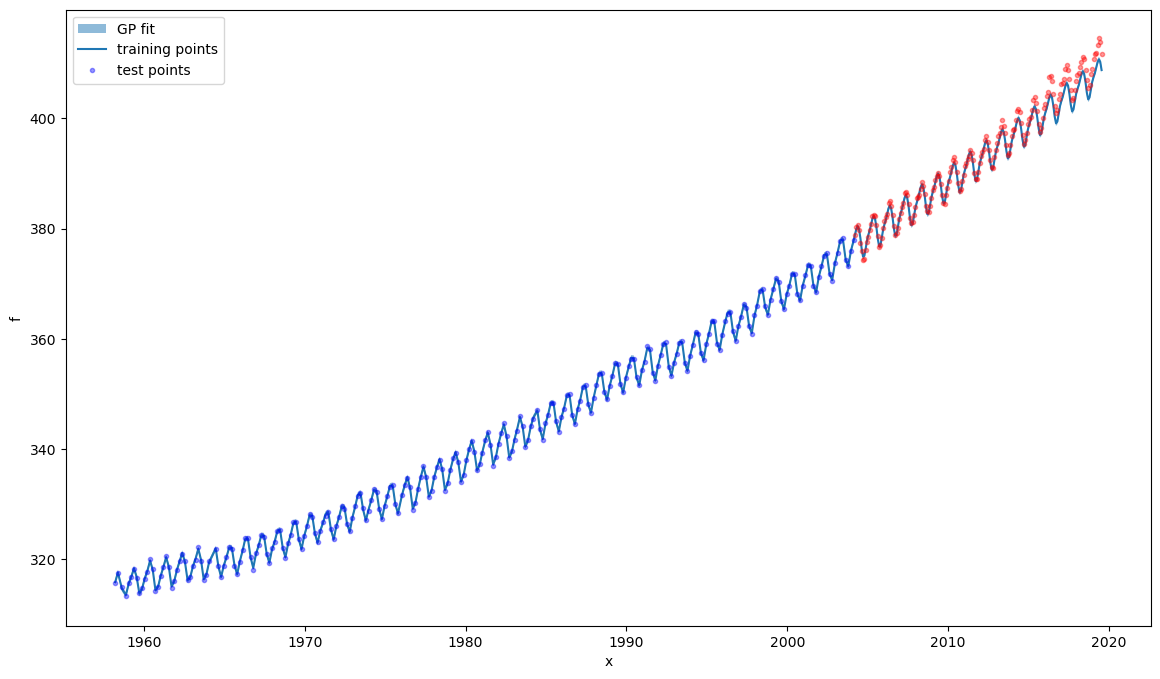

In [18]:
mean_func = GPy.mappings.Additive(GPy.mappings.Linear(1,1), GPy.mappings.Constant(1,1))
cov_func  = GPy.kern.Exponential(1) + GPy.kern.StdPeriodic(1, period=1.)*GPy.kern.RBF(1) # equivalent to k

m = GPy.models.GPRegression(X, Y, mean_function=mean_func, kernel=cov_func)

m.mapping.linmap.set_prior(GPy.priors.Gamma.from_EV(E=3, V=2))
m.mapping.constmap.set_prior(GPy.priors.Gaussian(mu=-2000., sigma=1000.))

m.Gaussian_noise.variance = 10.

m.optimize_restarts(20, robust=True)

# Get the moments of our model fit
mean, Cov = m.predict(Xnew)
# Set up plot environment
plt.figure(figsize=(14,8))
# Plot our optimised GP and training/test points
plot_gp(Xnew, mean, Cov)
plt.plot(X, Y, ".b", Xtest, Ytest, ".r", alpha=0.4);
# Annotate plot
plt.legend(labels=["GP fit","training points", "test points"])
# Preview model parameters
display(m)


## Footnote

Using Gaussian processes for machine learning gives you a powerful tool for learning latent functions in a Bayesian fashion, especially with a low number of observations. However, full GP regression can be quite time consuming, given it scales $\mathscr{O}(n^3)$ with the number of training points, $n$. There are methods for dealing with this: for example, sparse approximation or representing the regression problem as a state-space model. Each of these comes with their own assumptions and drawbacks. 

When using GPs in a computational setting, there are a wide range of tools that can be used depending on your preference of programming language and libraries. `GPy`, the library we use in these labs, is a well established Python library that was developed at the University of Sheffield. GPy is an open source package maintain by a community close to the Gaussian Process Summer School. Some other libraries that are commonly used for Gaussian processes include:

| Name     | Language | Comments |
|---------|-----------|----------|
| `GPy`     | Python | One of the earliest Python frameworks for Gaussian processes |
| `GPML`    | MATLAB | Examples and code used in Rasmussen & Williams GPML book |
| `GPstuff` | MATLAB, Octave, R | A MATLAB library with a wide arrange of inference methods, including HMC |
| `GPflow`  | Python | GP library built on `TensorFlow`, similar notation to `GPy` |
| `GPyTorch` | Python | GP library built on `PyTorch` |
| `Stan`    | R, Python, others | Probabilistic programming using MCMC that can be easily be used to model GPs |

### Credit

This notebook was written by Wil Ward. It adapted from notebooks by [Rich Wilkinson](https://rich-d-wilkinson.github.io/) and [Neil Lawrence](http://inverseprobability.com/). Additional writing and feedback was provided by Maria Skoularidou and Chunchao Ma.